<!--Header-->
<div style="background-color: #fff; color: black">
<div style="padding-bottom: 20px; display: flex; justify-content: space-between; align-items: flex-start;">
<div style="width: 60%;">
<h1 style="margin: 16px">TFG - Inteligencia Artificial</h1>
<p style="margin: 16px; padding-bottom: 0">Junio de 2025</p>
</div>
<div style="width: 40%; text-align: right">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" alt="Logo UOC">
</div>
</div>
<h2 style="text-align: justify; padding: 0 16px">Aplicación de técnicas de IA fiable en la predicción del índice de calidad de vida en personas con tratamiento oncológico mediante aprendizaje automático.</h2>
<div style="background-color: #000; width: 100%; height: 2px; margin: 24px 0"></div>
<div style="padding: 20px">
<h4 style="margin: 0 0; padding: 0 0">Pablo Pimàs Verge</h4>
<h5 style="margin: 0 0; padding: 0 0">Grado en Ingeniería Informática</h5>
<h5 style="margin: 0 0 4px; padding: 0 0">Inteligencia Artificial</h5>
<h4 style="margin: 8px 0 4px; padding: 0 0">Dra. María Moreno de Castro</h4>
<h4 style="margin: 0 0; padding: 0 0">Dr. Friman Sanchéz</h4>
</div>
</div>

# Fase 2
#### Tercera Parte

## Explicabilidad del modelo

### Objetivos

### Índice

### Importaciones

In [1]:
# Importaciones de librerías básicas
import joblib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import tempfile
import webbrowser

# Importaciones de Scikit-learn 
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import FixedThresholdClassifier
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

# Librerías XAI
import shap
from lime import lime_tabular
import dice_ml as dice

# Funciones auxiliares
import aux_functions as afn

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
plt.rc('font', size=10)
plt.rcParams["legend.frameon"] = False
sns.set_theme(
    style="white",
    palette="viridis",
    rc={
        "axes.spines.left": False,
        "axes.spines.bottom": False,
        "axes.spines.right": False,
        "axes.spines.top": False
    }
)
sns.set_style("white", {"axes.grid": False})

### Carga de los datos

In [3]:
X_train = pd.read_csv('./data/QLQ_C30_C23_X_train.csv')
X_test = pd.read_csv('./data/QLQ_C30_C23_X_test.csv')
X_cal = pd.read_csv('./data/QLQ_C30_C23_X_cal.csv')
y_train = pd.read_csv('./data/QLQ_C30_C23_y_train.csv').squeeze()
y_test = pd.read_csv('./data/QLQ_C30_C23_y_test.csv').squeeze()
y_cal = pd.read_csv('./data/QLQ_C30_C23_y_cal.csv').squeeze()

### Carga del modelo seleccionado

In [4]:
bundle = joblib.load('./models/CatBoost_bundle.pkl')
model = bundle['model']
threshold = bundle['threshold']
model_thresholded = FixedThresholdClassifier(model, threshold=threshold, response_method="predict_proba").fit(X_train, y_train)

## 1. Permutation feature importance

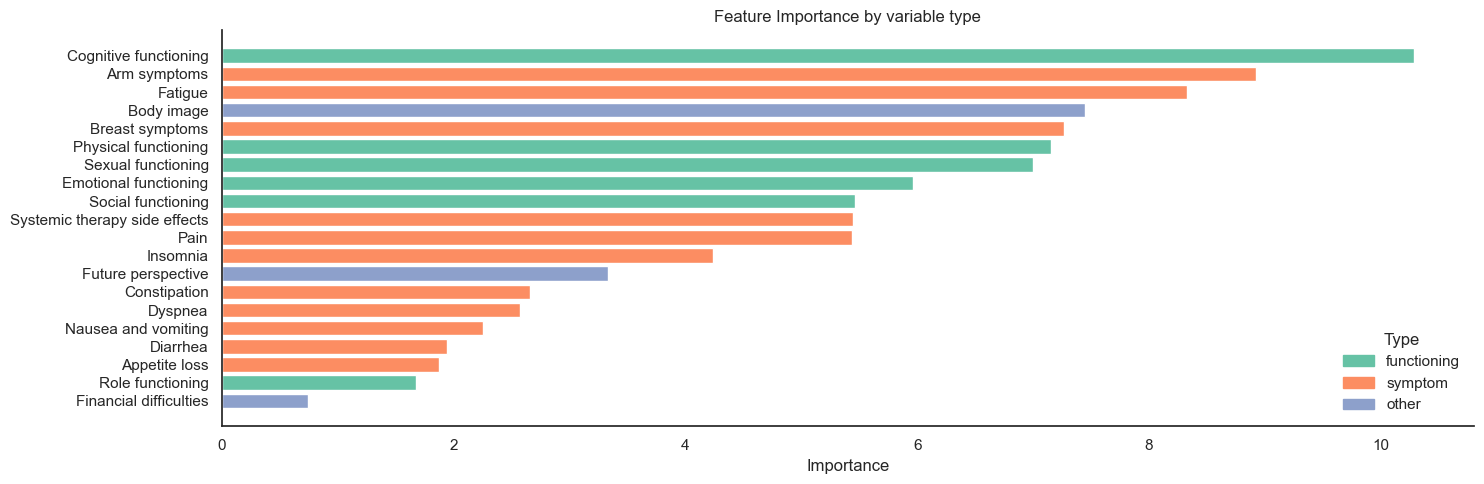

In [5]:
model_sorted_features_imp = sorted(
    zip(X_test.columns, model.feature_importances_),
    key=lambda x: x[1]
)
model_imp_features, model_imp_sorted = zip(*model_sorted_features_imp)
afn.viz_feature_importance(model_sorted_features_imp)

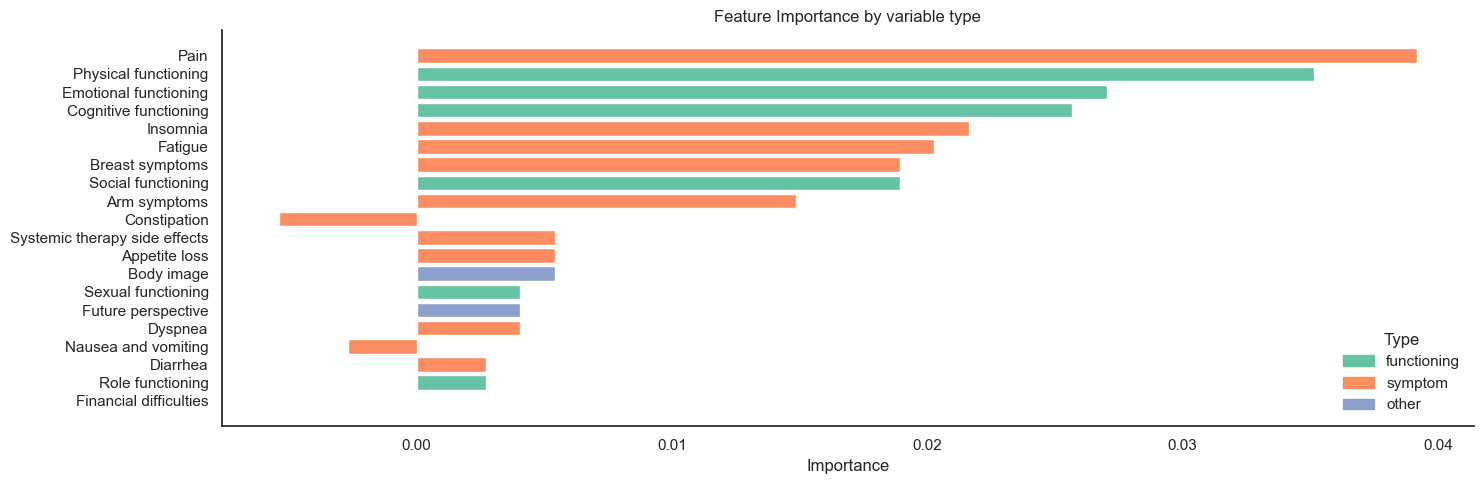

In [6]:
model_permutation_importance = permutation_importance(model, X_test, y_test, random_state=73)
model_sorted_permutations = sorted(
    zip(X_test.columns, model_permutation_importance.importances_mean),
    key=lambda x: abs(x[1])
)
afn.viz_feature_importance(model_sorted_permutations)

In [7]:

# Calcular la importancia por permutación para train y test
permutation_train = permutation_importance(model, X_train, y_train, random_state=23)
permutation_test = permutation_importance(model, X_test, y_test, random_state=23)
sorted_index = permutation_train.importances_mean.argsort()
sorted_features = X_train.columns[sorted_index]
train_importances = pd.DataFrame(permutation_train.importances[sorted_index].T, columns=sorted_features)
test_importances = pd.DataFrame(permutation_test.importances[sorted_index].T, columns=sorted_features)

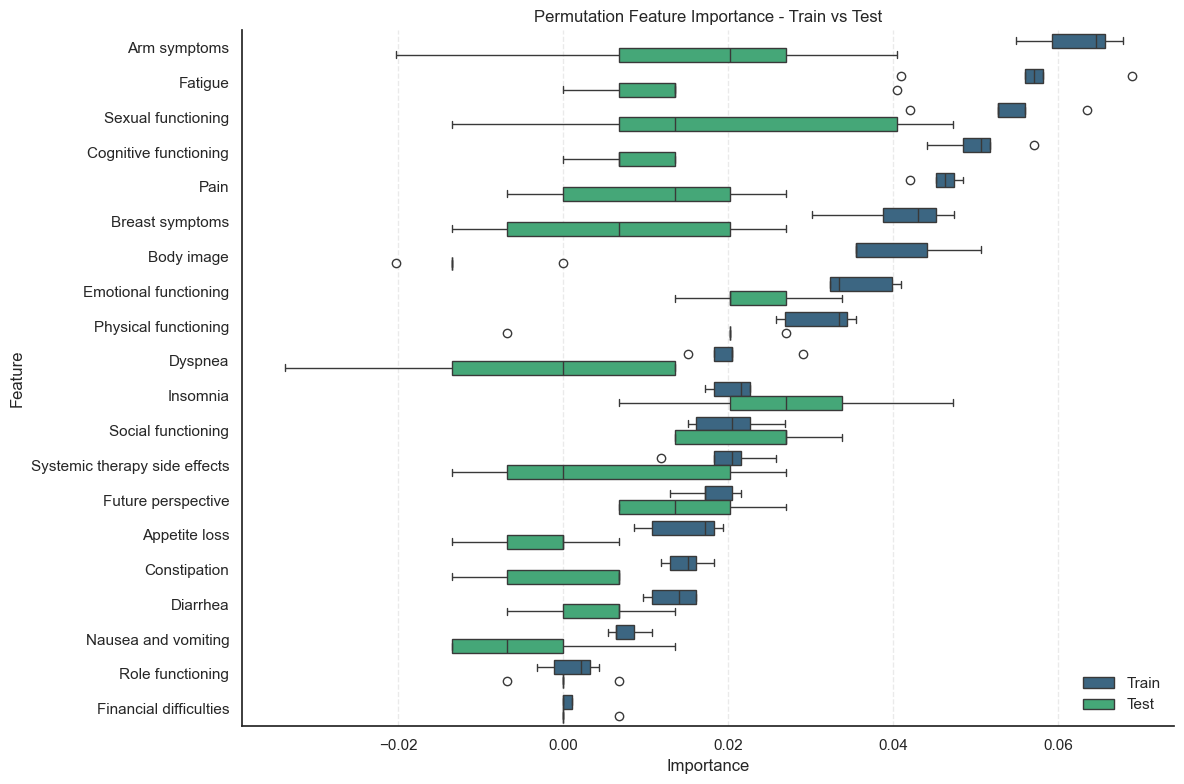

In [8]:
all_cols = train_importances.mean().abs().sort_values(ascending=False).index
train_long = train_importances[all_cols].melt(var_name='Feature', value_name='Importance')
train_long['Set'] = 'Train'
test_long = test_importances[all_cols].melt(var_name='Feature', value_name='Importance')
test_long['Set'] = 'Test'
combined = pd.concat([train_long, test_long], ignore_index=True)

plt.figure(figsize=(12, len(all_cols) * 0.4))  # Altura dinámica
sns.boxplot(data=combined, x='Importance', y='Feature', hue='Set', palette='viridis')
plt.title('Permutation Feature Importance - Train vs Test')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.legend(loc='lower right')
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
sns.despine()
plt.show()

## 2. Dependencia Parcial

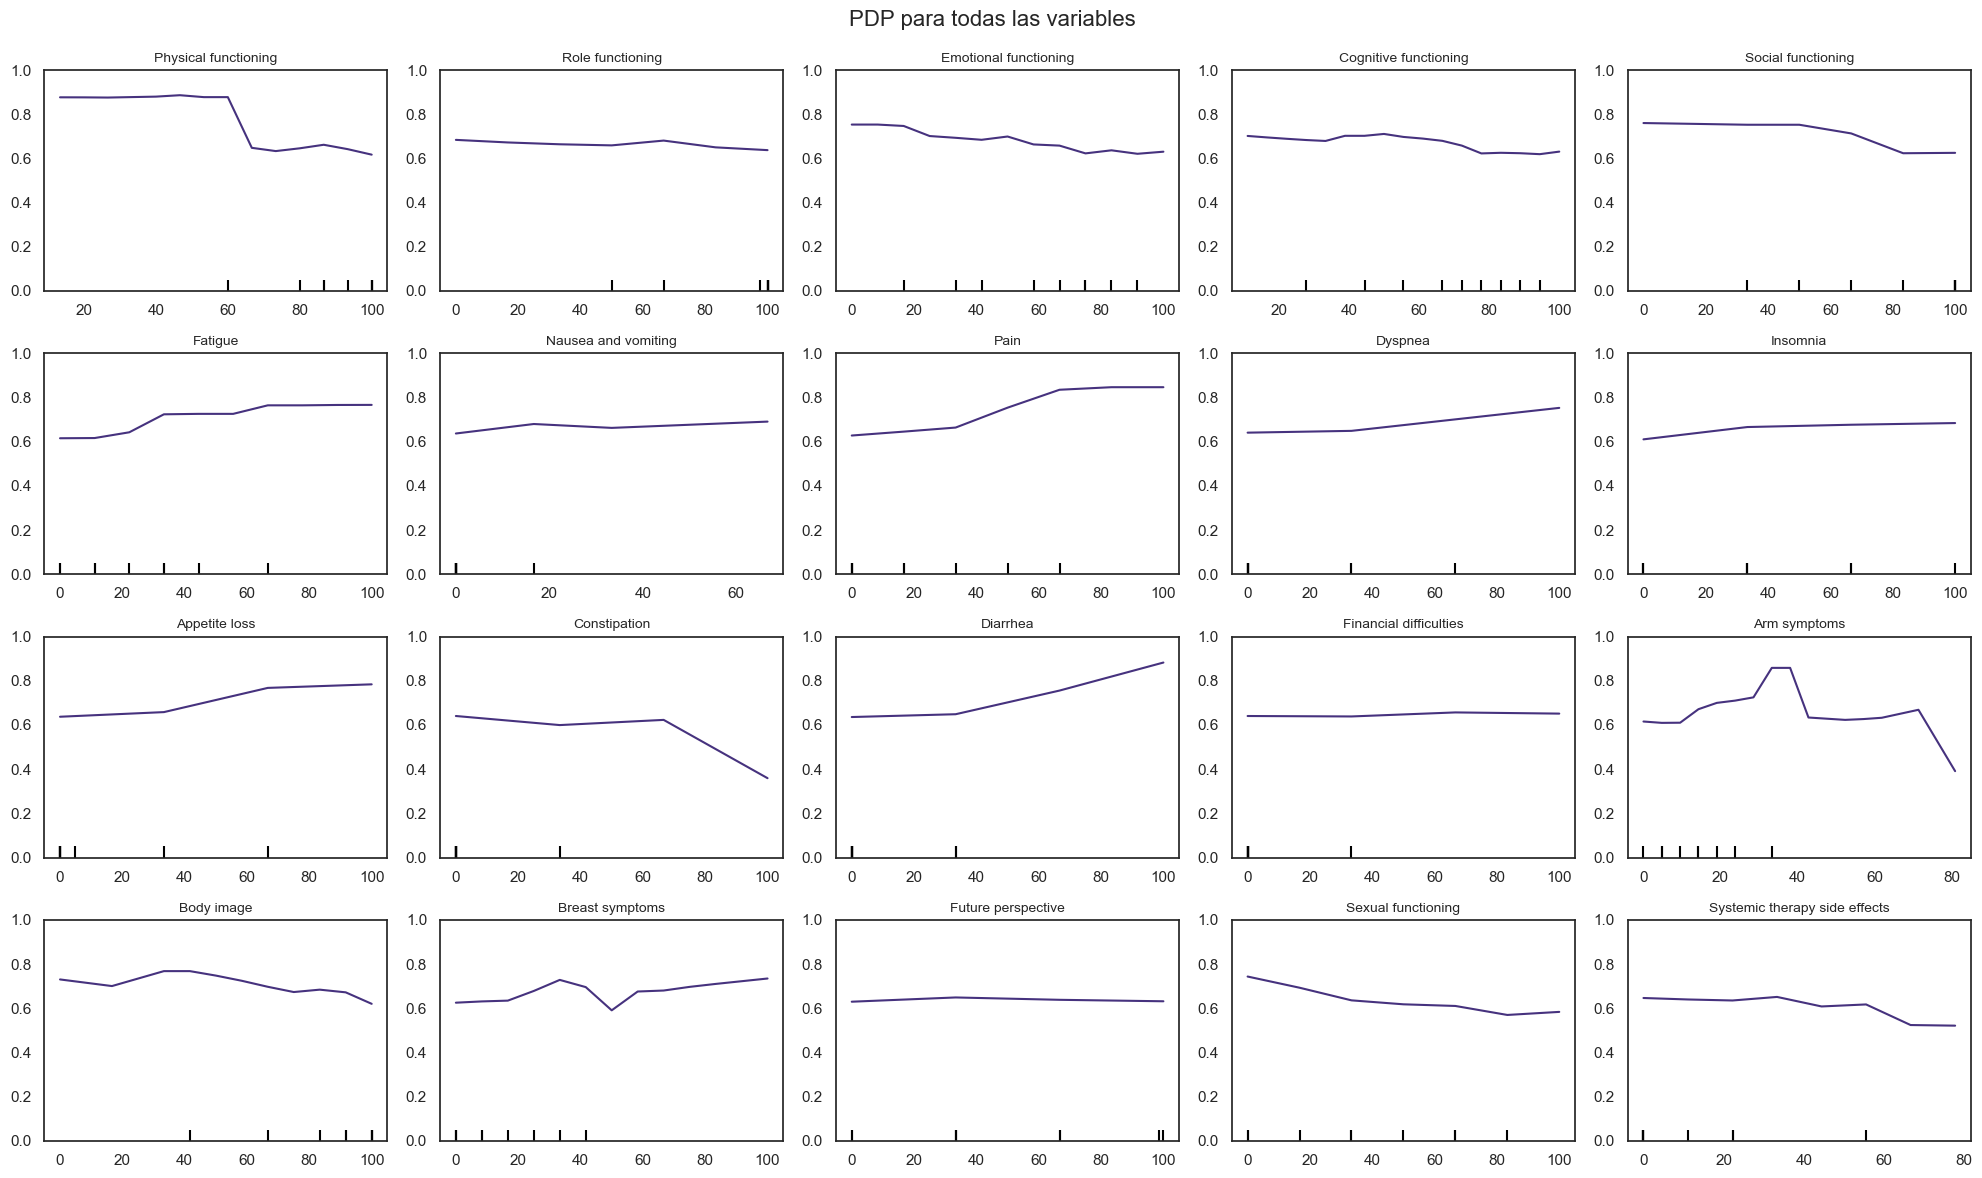

In [9]:
afn.viz_pdp_single(model, X_test)


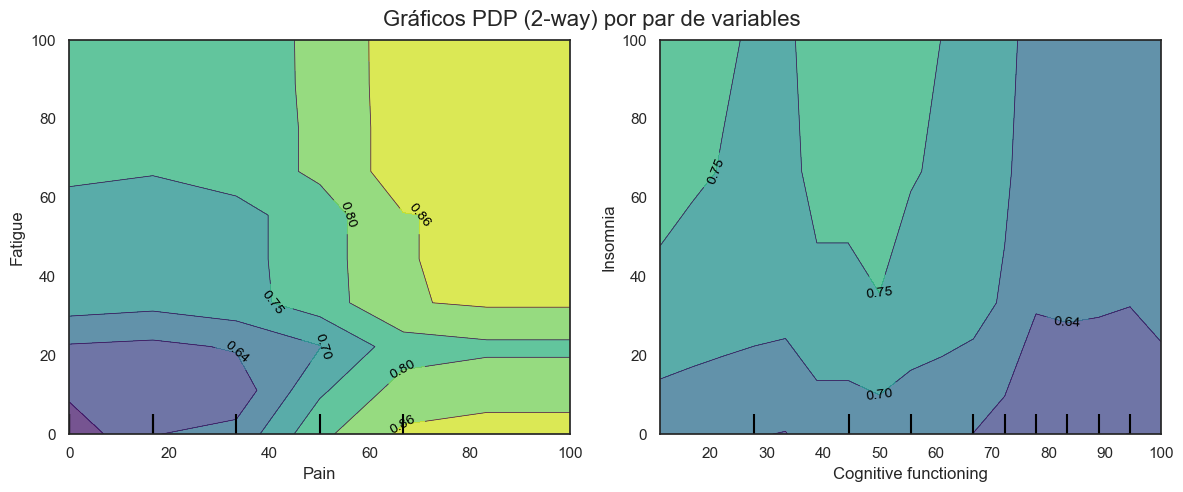

In [10]:
afn.viz_pdp_pairs(model, X_test, [('Pain', 'Fatigue'), ('Cognitive functioning', 'Insomnia')])

## 3. Expectación Condicional Individual

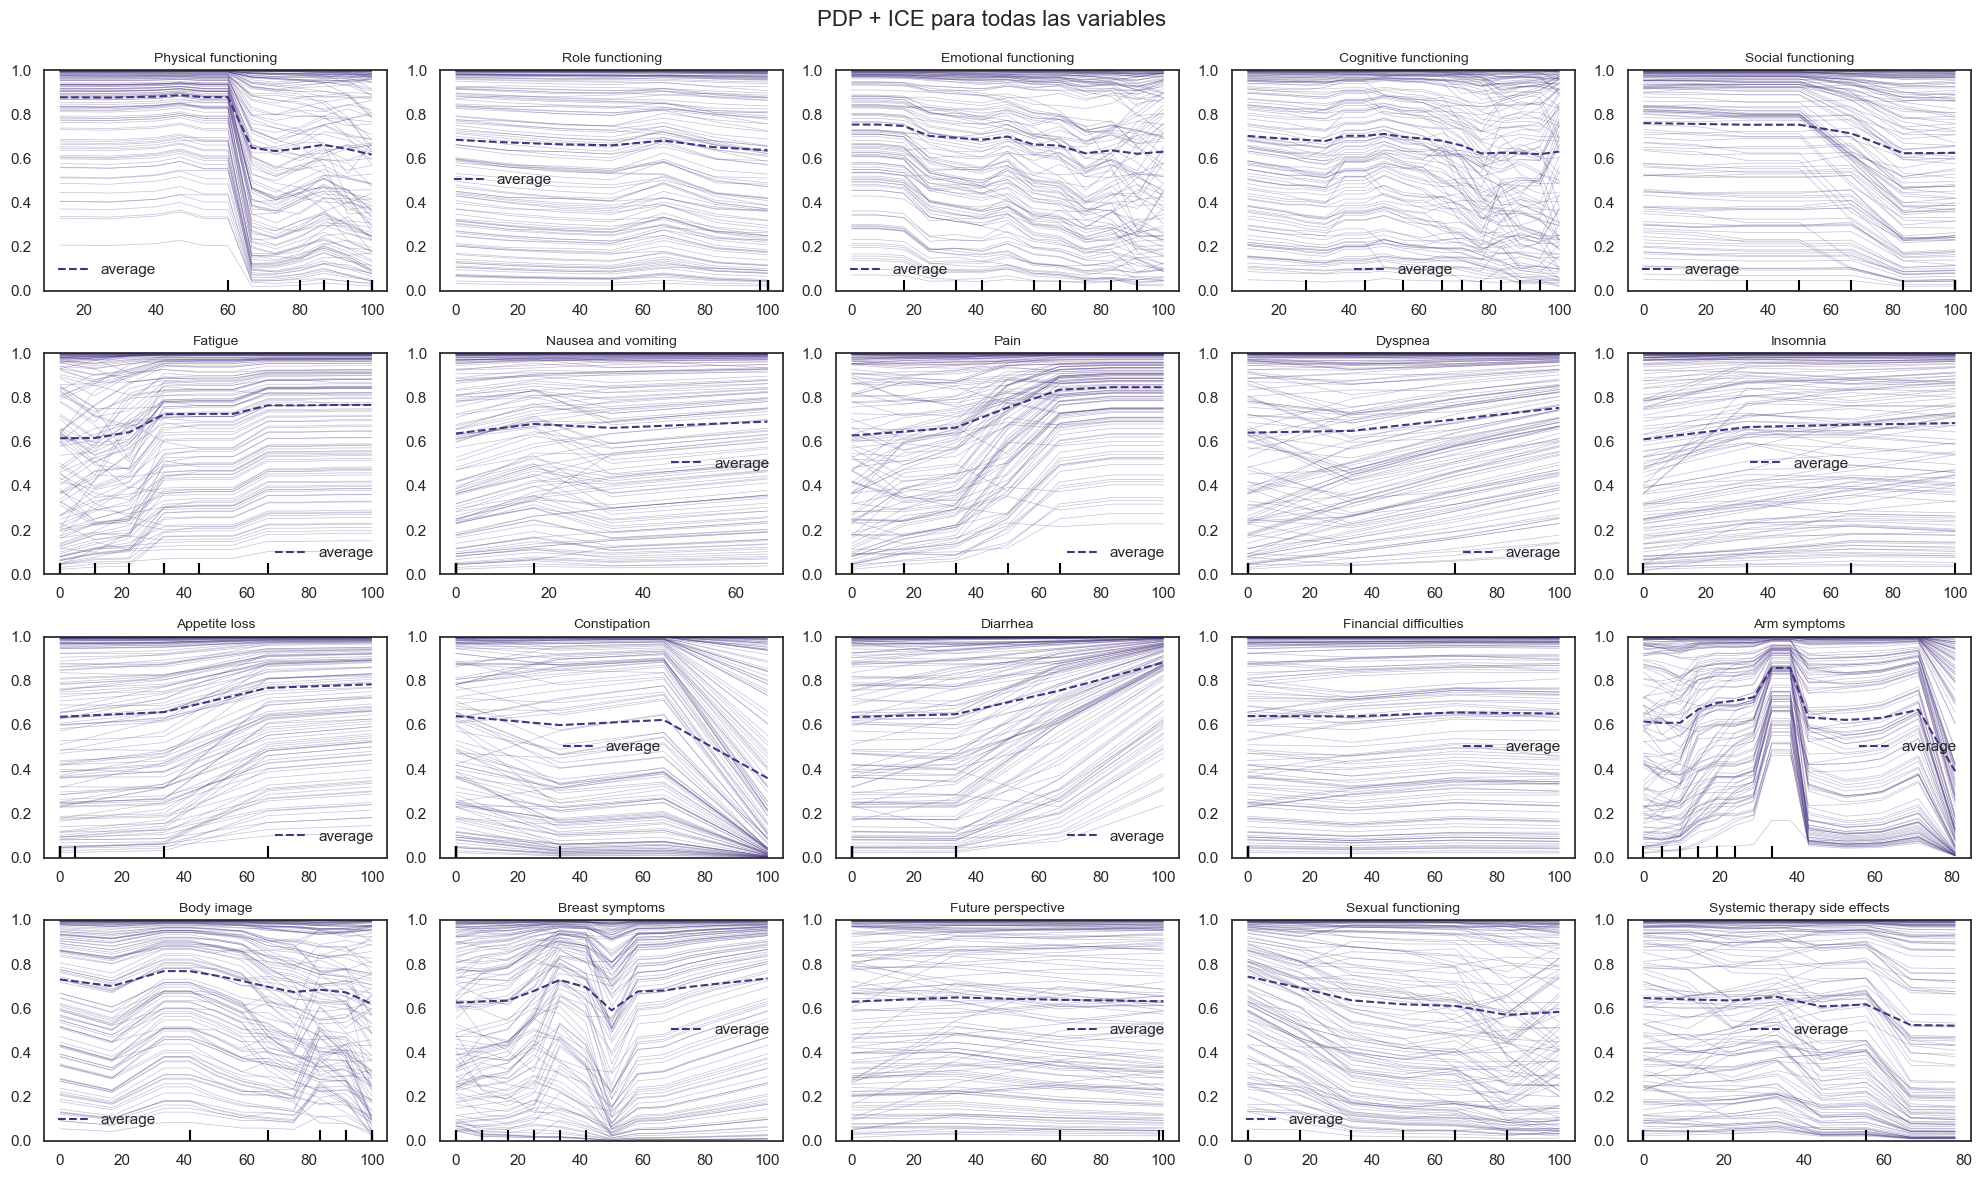

In [11]:
afn.viz_pdp_single(model, X_test, kind='both')

## 4. LIME

In [12]:
lime_idx = np.random.randint(0, len(X_test))
afn.single_prediction(model, model_thresholded, threshold, X_test, y_test, lime_idx)

Physical functioning  Role functioning  Emotional functioning  \
4                 86.67             83.33                  83.33   

   Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
4                  83.33              100.00    33.33                33.33   

   Pain  Dyspnea  Insomnia  Appetite loss  Constipation  Diarrhea  \
4 16.67    33.33      0.00           0.00          0.00     33.33   

   Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
4                    0.00          9.52       91.67             8.33   

   Future perspective  Sexual functioning  Systemic therapy side effects  
4               66.67               83.33                           0.00

Probabilidad de las clases de QoL: [Aceptable: 0.56, Mejorable: 0.44]
QoL predicha ajustada con umbral 0.38: 1.0
QoL real: 0.0


In [13]:
l_explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode='classification',
    feature_names=X_train.columns,
    class_names=['Aceptable=0','Mejorable=1'],
    random_state=73
)
explanation = l_explainer.explain_instance(
    X_test.iloc[lime_idx].values,
    model.predict_proba)
explanation.show_in_notebook()

In [14]:
y_pred_thres = model_thresholded.predict(X_test)
fn_index = afn.show_random_false_prediction(model, y_pred_thres, threshold, X_test, y_test)

Physical functioning  Role functioning  Emotional functioning  \
74                100.00            100.00                  58.33   

    Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
74                  72.22              100.00    22.22                 0.00   

    Pain  Dyspnea  Insomnia  Appetite loss  Constipation  Diarrhea  \
74  0.00     0.00      0.00           0.00          0.00      0.00   

    Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
74                    0.00         14.29      100.00             0.00   

    Future perspective  Sexual functioning  Systemic therapy side effects  
74              100.00               66.67                           0.00

Predicción sin ajustar: [0.75 0.25]
Predicción ajustada con umbral (0.378): 0 (0.25)
QoL real: 1.0
Índice: 74


In [15]:
explanation = l_explainer.explain_instance(
    X_test.iloc[fn_index].values,
    model.predict_proba)
explanation.show_in_notebook()

In [16]:
fp_index = afn.show_random_false_prediction(model, y_pred_thres, threshold, X_test, y_test, negative=False)

Physical functioning  Role functioning  Emotional functioning  \
68                 93.33            100.00                  75.00   

    Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
68                  72.22              100.00    44.44                 0.00   

    Pain  Dyspnea  Insomnia  Appetite loss  Constipation  Diarrhea  \
68 33.33     0.00     33.33          33.33          0.00      0.00   

    Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
68                    0.00         23.81       75.00             0.00   

    Future perspective  Sexual functioning  Systemic therapy side effects  
68               66.67                0.00                          11.11

Predicción sin ajustar: [0.13 0.87]
Predicción ajustada con umbral (0.378): 1 (0.87)
QoL real: 0.0
Índice: 68


In [17]:
explanation = l_explainer.explain_instance(
    X_test.iloc[fp_index].values,
    model.predict_proba)
explanation.show_in_notebook()

## 5. DiCe

In [18]:
train_df = X_train.copy()
train_df['QoL'] = y_train
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Physical functioning           928 non-null    float64
 1   Role functioning               928 non-null    float64
 2   Emotional functioning          928 non-null    float64
 3   Cognitive functioning          928 non-null    float64
 4   Social functioning             928 non-null    float64
 5   Fatigue                        928 non-null    float64
 6   Nausea and vomiting            928 non-null    float64
 7   Pain                           928 non-null    float64
 8   Dyspnea                        928 non-null    float64
 9   Insomnia                       928 non-null    float64
 10  Appetite loss                  928 non-null    float64
 11  Constipation                   928 non-null    float64
 12  Diarrhea                       928 non-null    flo

In [19]:
dice_data = dice.Data(
    dataframe=train_df, 
    outcome_name='QoL',
    continuous_features=[],
)
dice_model = dice.Model(model=model, model_type='classifier', backend="sklearn")

In [21]:
dice_index = np.random.randint(0, len(X_test))
afn.single_prediction(model, model_thresholded, threshold, X_test, y_test, dice_index)

Physical functioning  Role functioning  Emotional functioning  \
72                100.00            100.00                  75.00   

    Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
72                  83.33              100.00     0.00                 0.00   

    Pain  Dyspnea  Insomnia  Appetite loss  Constipation  Diarrhea  \
72  0.00     0.00      0.00           0.00          0.00      0.00   

    Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
72                    0.00          0.00      100.00            25.00   

    Future perspective  Sexual functioning  Systemic therapy side effects  
72                0.00               66.67                           0.00

Probabilidad de las clases de QoL: [Aceptable: 0.86, Mejorable: 0.14]
QoL predicha ajustada con umbral 0.38: 0.0
QoL real: 1.0


In [22]:
dice_explainer = dice.Dice(dice_data, dice_model, method='random')
dice_cfactuals = dice_explainer.generate_counterfactuals(
    X_test.iloc[[70]], # caso 70
    total_CFs=5,
    desired_class="opposite",
    features_to_vary=['Fatigue', 'Pain', 'Cognitive functioning'],
    verbose=True
)  

100%|██████████| 1/1 [00:00<00:00, 17.78it/s]

Diverse Counterfactuals found! total time taken: 00 min 00 sec


In [23]:
dice_cfactuals.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1.0)


Physical functioning  Role functioning  Emotional functioning  \
0                 86.67             83.33                  83.33   

   Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
0                  88.89              100.00     0.00                 0.00   

   Pain  Dyspnea  Insomnia  ...  Constipation  Diarrhea  \
0 16.67     0.00     33.33  ...          0.00      0.00   

   Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
0                    0.00         19.05       91.67             0.00   

   Future perspective  Sexual functioning  Systemic therapy side effects  QoL  
0               66.67               33.33                          22.22 1.00  

[1 rows x 21 columns]


Diverse Counterfactual set (new outcome: 0.0)


Physical functioning Role functioning Emotional functioning  \
0                    -                -                     -   
1                    -                -                     -   
2                    -                -                     -   
3                    -                -                     -   
4                    -                -                     -   

  Cognitive functioning Social functioning             Fatigue  \
0     94.44444444444444                  -   33.33333333333333   
1     72.22222222222223                  -  22.222222222222225   
2                     -                  -   33.33333333333333   
3     83.33333333333334                  -   55.55555555555555   
4                     -                  -  11.111111111111107   

  Nausea and vomiting Pain Dyspnea Insomnia  ... Constipation Diarrhea  \
0                   -    -       -        -  ...            -        -   
1                   -    -       -        -  ...            -        -   
2                   -    -       -        -  ...            -        -   
3                   -    -       -        -  ...            -        -   
4                   -    -       -        -  ...            -        -   

  Financial difficulties Arm symptoms Body image Breast symptoms  \
0                      -            -          -               -   
1                      -            -          -               -   
2                      -            -          -               -   
3                      -            -          -               -   
4                      -            -          -               -   

  Future perspective Sexual functioning Systemic therapy side effects  QoL  
0                  -                  -                             -  0.0  
1                  -                  -                             -  0.0  
2                  -                  -                             -  0.0  
3                  -                  -                             -  0.0  
4                  -                  -                             -  0.0  

[5 rows x 21 columns]

## 6. SHAP

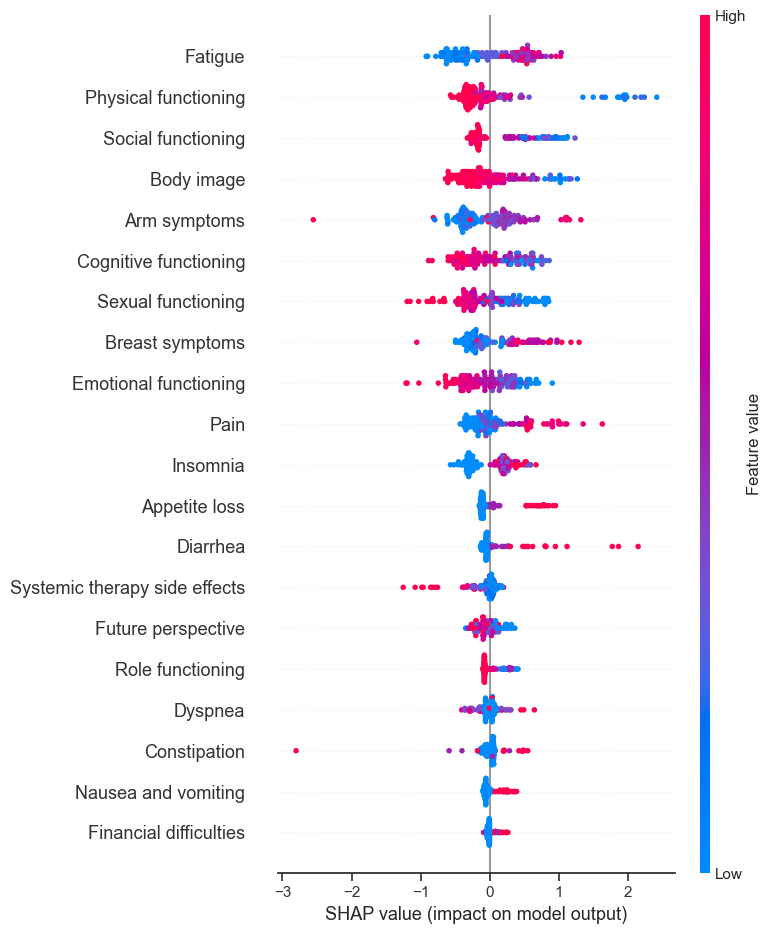

In [24]:
shap.initjs()
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

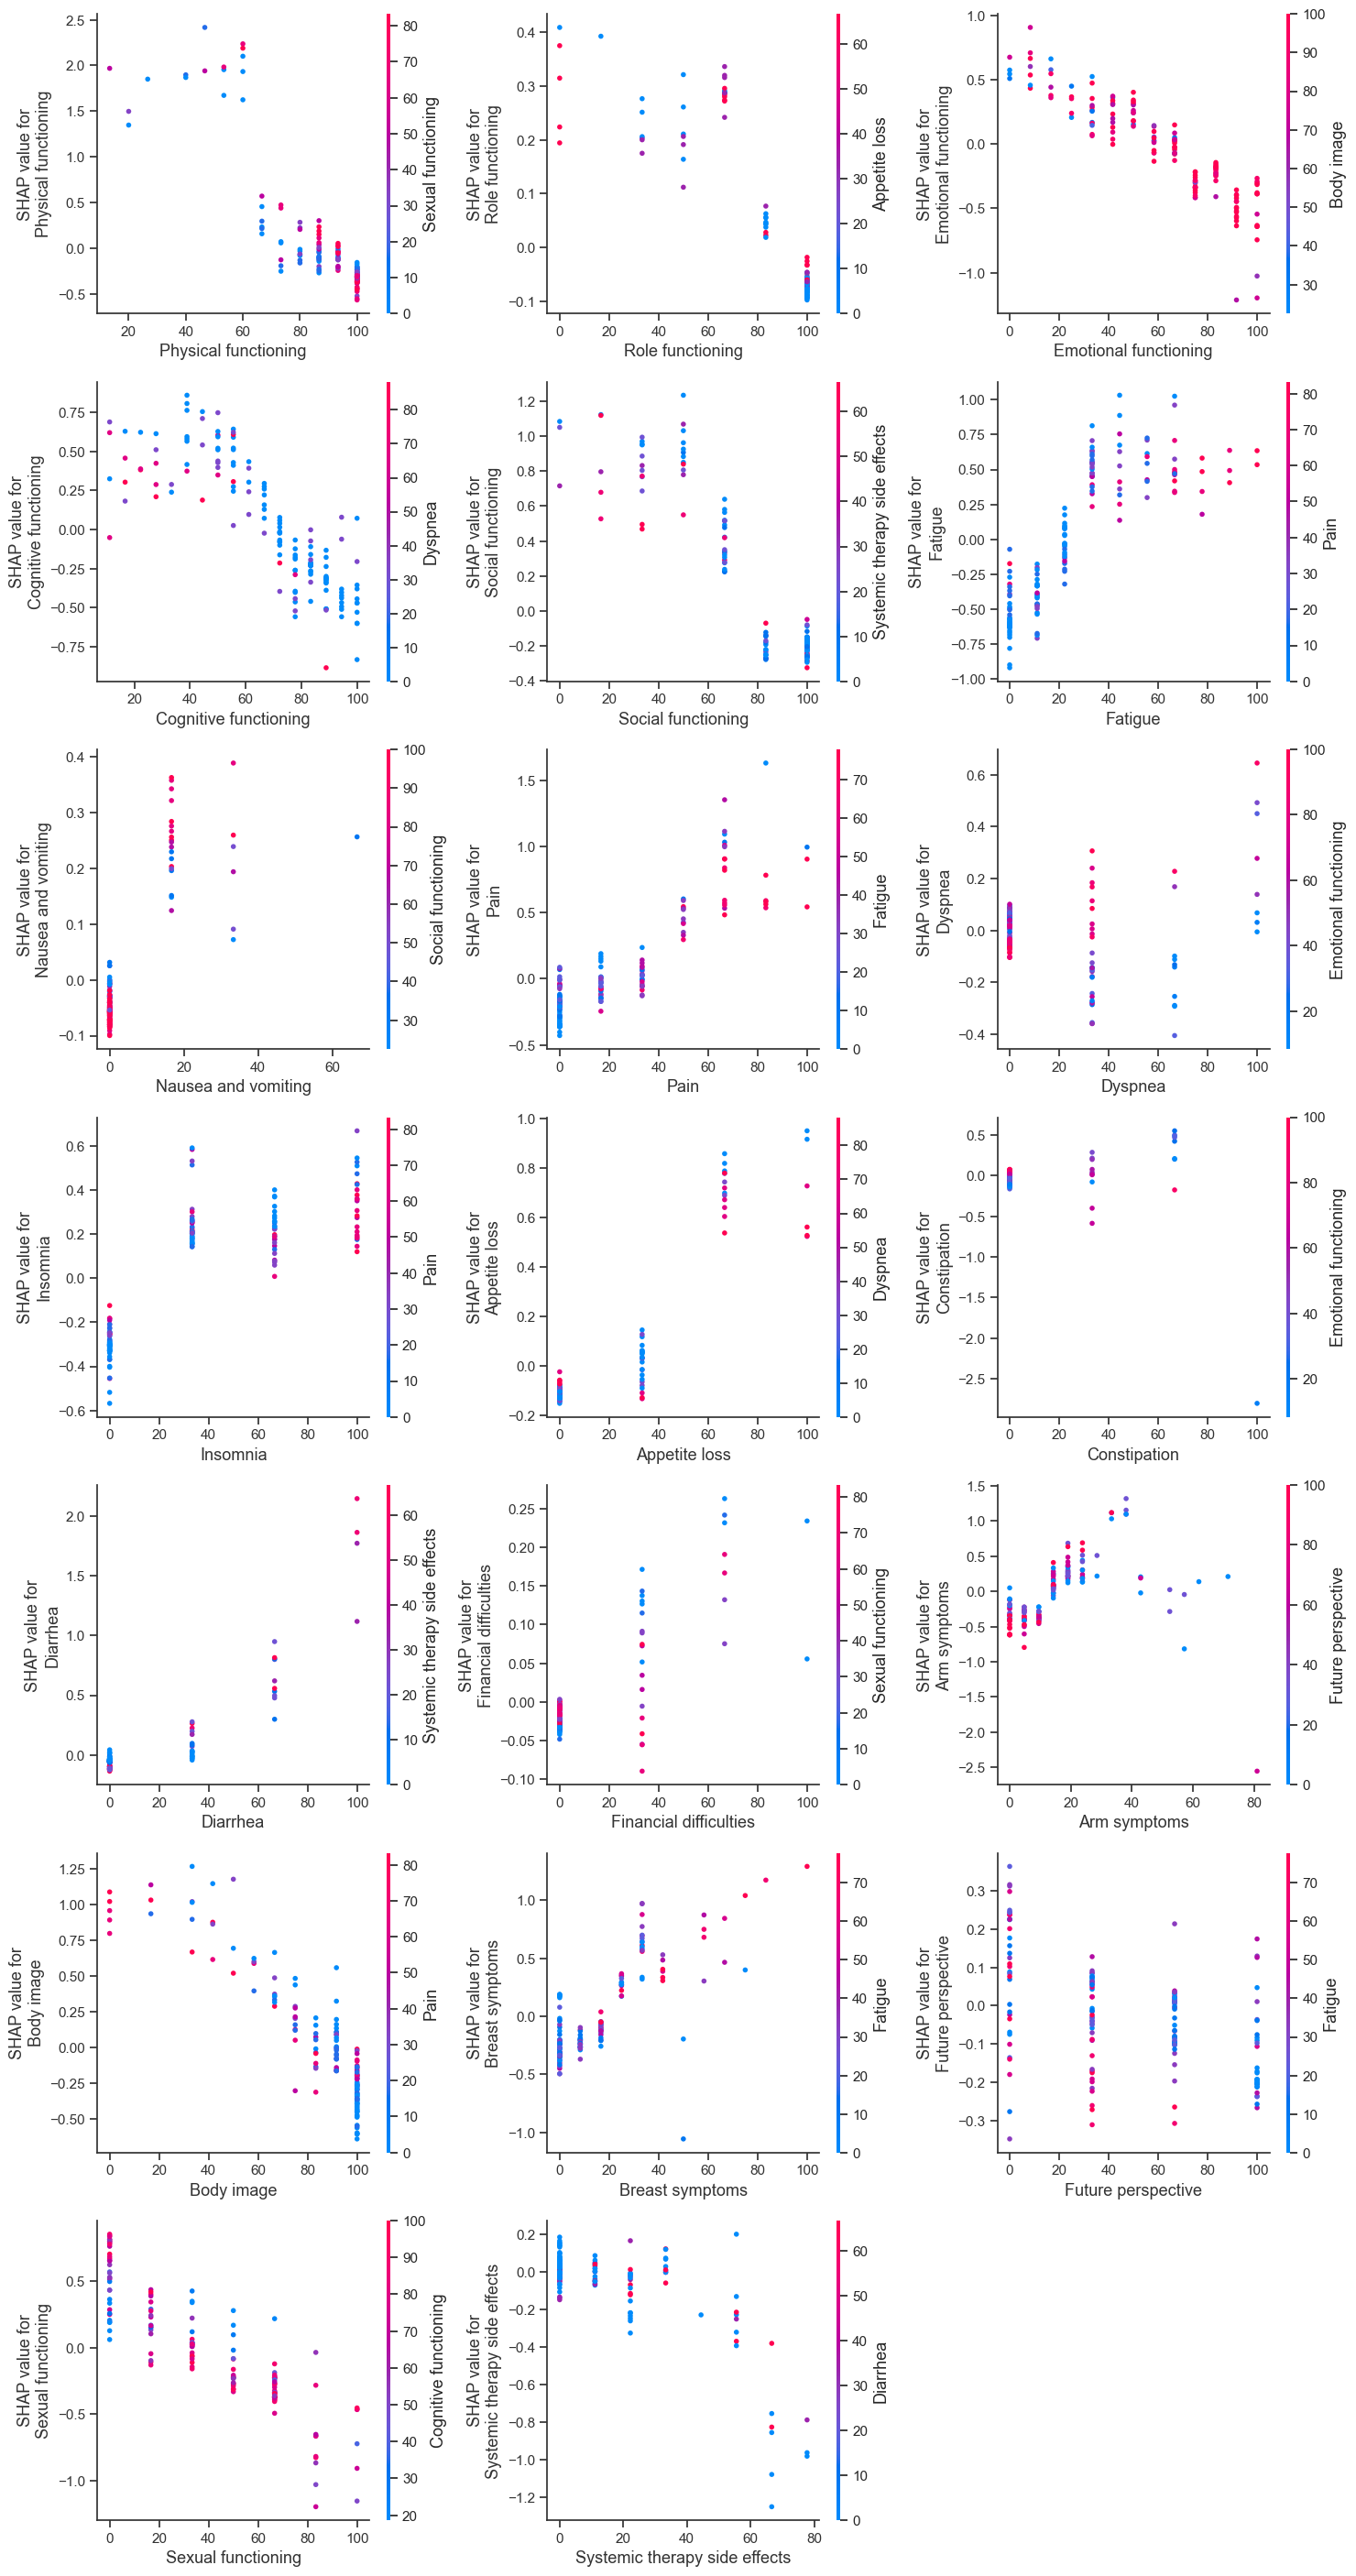

In [25]:
n_features = len(X_test.columns)
cols = 3
rows = (len(X_test.columns) + cols - 1)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, feature in enumerate(X_test.columns):
    shap.dependence_plot(feature, shap_values, X_test, ax=axes[i], show=False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [27]:
shap_index = np.random.randint(0, len(X_test))
afn.single_prediction(model, model_thresholded, threshold, X_test, y_test, shap_index)

Physical functioning  Role functioning  Emotional functioning  \
33                 86.67            100.00                  83.33   

    Cognitive functioning  Social functioning  Fatigue  Nausea and vomiting  \
33                  83.33              100.00    22.22                 0.00   

    Pain  Dyspnea  Insomnia  Appetite loss  Constipation  Diarrhea  \
33 16.67    33.33      0.00           0.00          0.00      0.00   

    Financial difficulties  Arm symptoms  Body image  Breast symptoms  \
33                    0.00         14.29      100.00             0.00   

    Future perspective  Sexual functioning  Systemic therapy side effects  
33               66.67                0.00                          11.11

Probabilidad de las clases de QoL: [Aceptable: 0.34, Mejorable: 0.66]
QoL predicha ajustada con umbral 0.38: 1.0
QoL real: 0.0


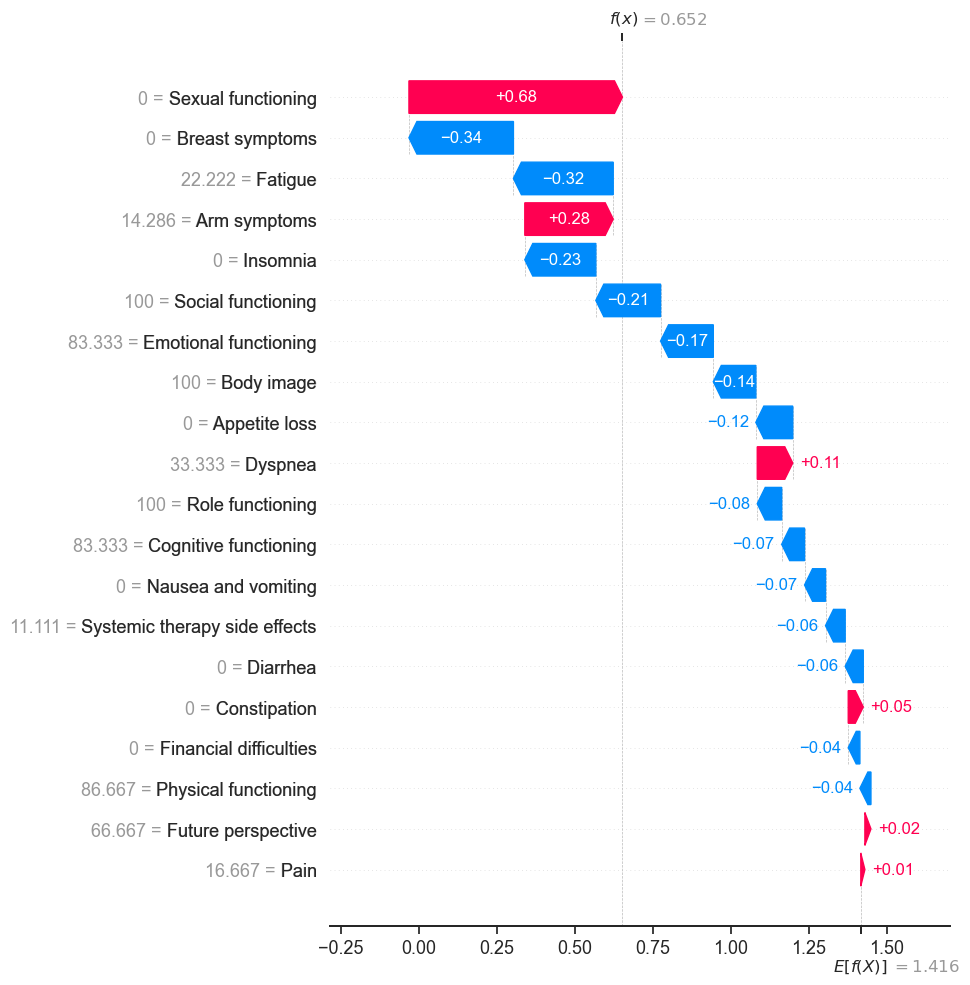

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[shap_index], max_display=20)

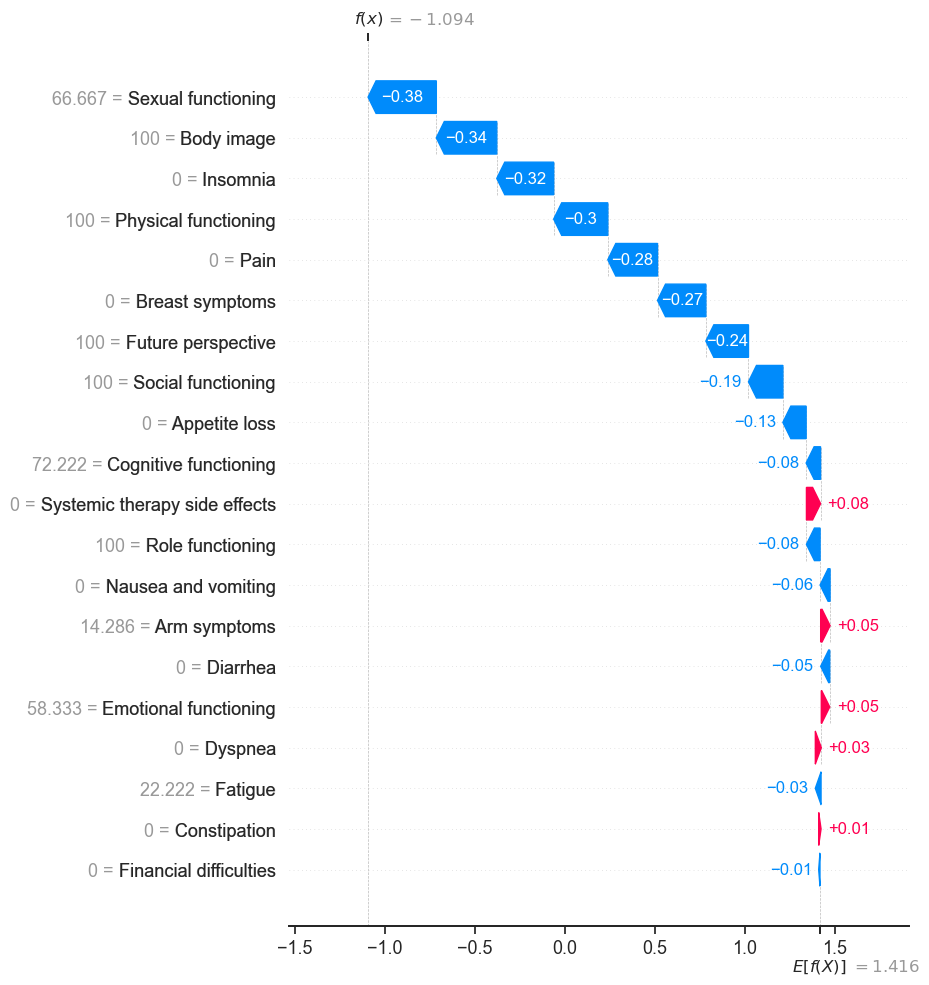

In [29]:
shap.plots.waterfall(shap_values[fn_index], max_display=20)

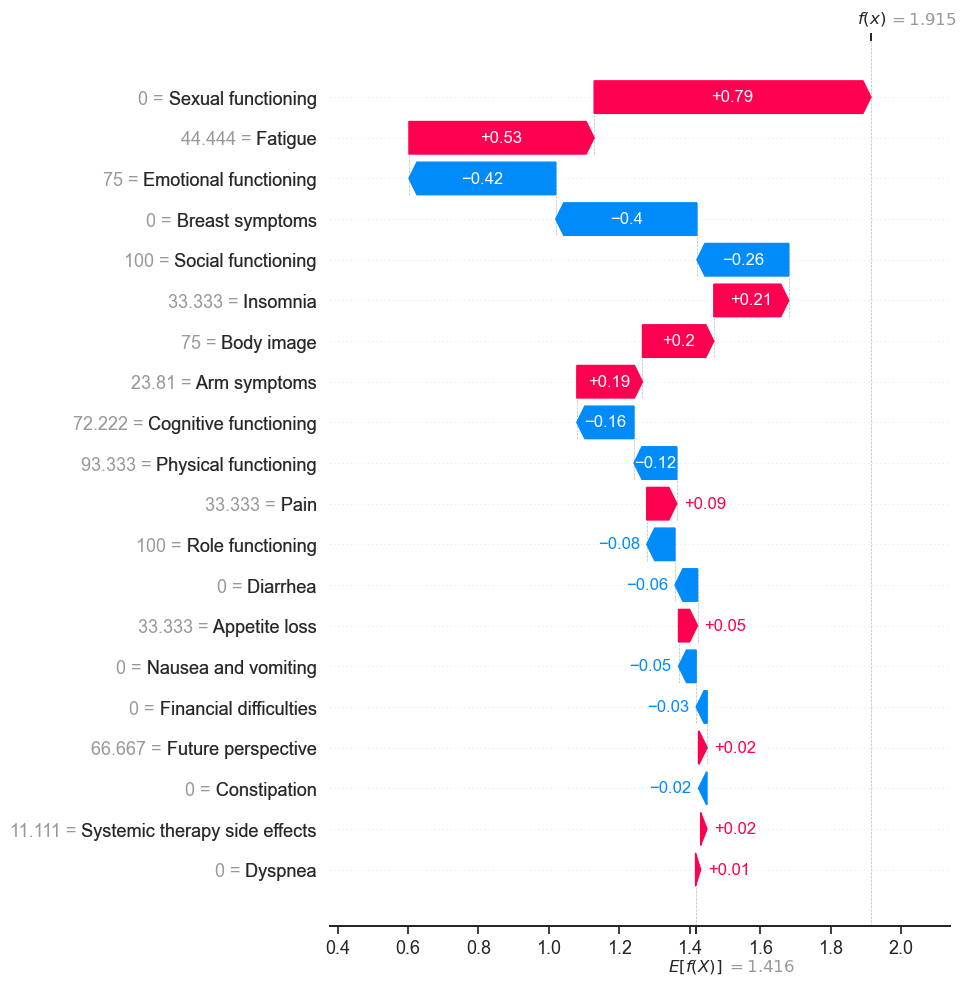

In [30]:
shap.plots.waterfall(shap_values[fp_index], max_display=20)